<a href="https://colab.research.google.com/github/kairamilanifitria/NLP-Projects/blob/main/Project%202%20Text%20Summarization/3_Test_BERT_Abstractive%2B_Extractive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# load dataset

In [1]:
import pandas as pd

# Load the dataset
test_df = pd.read_csv('/content/drive/MyDrive/Bootcamp AI/Dataset/Task2 : Text Summarization/fine-tune_dataset/test_df.csv')

# Basic overview
print(test_df.shape)
print(test_df.info())
print(test_df.isnull().sum())

(9775, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9775 entries, 0 to 9774
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   9775 non-null   int64 
 1   url                  9775 non-null   object
 2   text                 9775 non-null   object
 3   abstractive_summary  9775 non-null   object
 4   extractive_summary   9775 non-null   object
dtypes: int64(1), object(4)
memory usage: 382.0+ KB
None
id                     0
url                    0
text                   0
abstractive_summary    0
extractive_summary     0
dtype: int64


In [2]:
test_df = test_df.drop(['id', 'url'], axis=1)

In [3]:
test_df.iloc[1]

,1
text,liputan6 com yogyakarta datang kereta api dari...
abstractive_summary,berangkat kereta api dari jalur selatan kembal...
extractive_summary,demikian ungkap orang tugas pt kereta api indo...


In [4]:
test_df_subset = test_df.head(500) # we gonna use this dataset to generate result summarization

In [5]:
test_df_subset.shape

(500, 3)

# **generate summarization = BERT huggingface raw model**
## cahya/bert2bert-indonesian-summarization

In [ ]:
!pip install datasets transformers torch accelerate rouge-score

In [ ]:
import pandas as pd
import torch
from datasets import load_dataset, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer, DataCollatorForSeq2Seq, EncoderDecoderModel, AutoModelForSeq2SeqLM, AutoTokenizer # Import AutoModelForSeq2SeqLM and AutoTokenizer
from transformers import pipeline

In [ ]:
# Check if GPU is available and set device accordingly
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [ ]:
!pip install tqdm  # Install tqdm if you haven't already
from tqdm import tqdm

import pandas as pd

def generate_summaries_for_df(df):
    model_path = "cahya/bert2bert-indonesian-summarization"
    abstractive_summarizer = EncoderDecoderModel.from_pretrained(model_path).to(device)
    tokenizer = BertTokenizer.from_pretrained("cahya/bert2bert-indonesian-summarization")
    tokenizer.bos_token = tokenizer.cls_token
    tokenizer.eos_token = tokenizer.sep_token

    # Generate summary using your model

    abstractive_summaries = []

    # Wrap the loop with tqdm to display a progress bar
    for text in tqdm(df['text'], desc="Generating Summaries"):
        try:
            # Call the original generate_summaries function if it exists, or define it here
            # If 'generate_summaries' is a separate function, ensure it's defined and accessible
            # Example usage if you have a separate 'generate_summaries' function:
            # abstractive_summary = generate_summaries(text, abstractive_summarizer, tokenizer, device)
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)  # Adjust max_length if needed
            summary_ids = abstractive_summarizer.generate(**inputs, max_length=100)  # Adjust max_length if needed
            abstractive_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

            abstractive_summaries.append(abstractive_summary)
        except Exception as e:
            print(f"Error generating summary for text: {text[:50]}...")  # Print a message for debugging
            print(f"Error: {e}")  # Print the error
            abstractive_summaries.append("")  # Append an empty string to keep the output length consistent

    return pd.DataFrame({'abstractive_summary': abstractive_summaries})

# Assuming test_df_subset is already defined
summary_df_subset_raw = generate_summaries_for_df(test_df_subset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.09k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/999M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/230k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Generating Summaries: 100%|██████████| 500/500 [07:53<00:00,  1.06it/s]


In [ ]:
print(summary_df_subset_raw)

                                   abstractive_summary
0    cekal tommy soeharto kali ini kaitkan dengan s...
1    yogyakarta datang kereta api dari jalur selata...
2    jaksa agung bakal aju tinjau kembali pk hadap ...
3    ratusan ormas islam di ambon gelar unjuk rasa ...
4    solusi yang dianggap unik justru lontar menter...
..                                                 ...
495  kondisi aceh tengah dalam ada kritis pasok bah...
496  beberapa hari pascakematian ketua pdp theys hi...
497  proyek yang bakal telan biaya sekitar rp 42 mi...
498  buntut kini keluarga para curi tuntut polisi w...
499  komisi ix dpr ri janji segera selesai pilih de...

[500 rows x 1 columns]


In [ ]:
# download summary_df_subset_raw into csv
from google.colab import files

summary_df_subset_raw.to_csv('Abstractive_raw_BERT.csv', index=False)
files.download('Abstractive_raw_BERT.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# make a code to calculate ROUGE-1, ROUGE-2 and ROUGE-L score from est_df_subset in column "abstractive_summary" as references, and summary_df_subset as candidate

from rouge_score import rouge_scorer

def calculate_rouge_scores(references, candidates):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = []
    for ref, cand in zip(references, candidates):
        scores = scorer.score(ref, cand)
        rouge_scores.append(scores)
    return rouge_scores

references = test_df_subset['abstractive_summary'].tolist()  # Assuming 'abstractive_summary' is your reference column
candidates = summary_df_subset_raw['summary'].tolist()

rouge_scores = calculate_rouge_scores(references, candidates)

# Calculate average scores
rouge1_scores = [score['rouge1'].fmeasure for score in rouge_scores]
rouge2_scores = [score['rouge2'].fmeasure for score in rouge_scores]
rougeL_scores = [score['rougeL'].fmeasure for score in rouge_scores]

avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores) if rouge1_scores else 0
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores) if rouge2_scores else 0
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores) if rougeL_scores else 0

print(f"Average ROUGE-1 raw BERT model summary")
print(f"Average ROUGE-1: {avg_rouge1}")
print(f"Average ROUGE-2: {avg_rouge2}")
print(f"Average ROUGE-L: {avg_rougeL}")


Average ROUGE-1 raw BERT model summary
Average ROUGE-1: 0.3914424635664468
Average ROUGE-2: 0.1982647089710902
Average ROUGE-L: 0.3065409894499913


RAW model : compare to extractive test set

In [ ]:
# make a code to calculate ROUGE-1, ROUGE-2 and ROUGE-L score from est_df_subset in column "abstractive_summary" as references, and summary_df_subset as candidate

from rouge_score import rouge_scorer

def calculate_rouge_scores(references, candidates):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = []
    for ref, cand in zip(references, candidates):
        scores = scorer.score(ref, cand)
        rouge_scores.append(scores)
    return rouge_scores

references = test_df_subset['extractive_summary'].tolist()  # Assuming 'abstractive_summary' is your reference column
candidates = summary_df_subset_raw['summary'].tolist()

rouge_scores = calculate_rouge_scores(references, candidates)

# Calculate average scores
rouge1_scores = [score['rouge1'].fmeasure for score in rouge_scores]
rouge2_scores = [score['rouge2'].fmeasure for score in rouge_scores]
rougeL_scores = [score['rougeL'].fmeasure for score in rouge_scores]

avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores) if rouge1_scores else 0
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores) if rouge2_scores else 0
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores) if rougeL_scores else 0

print(f"Average ROUGE-1 raw BERT model")
print(f"Average ROUGE-1: {avg_rouge1}")
print(f"Average ROUGE-2: {avg_rouge2}")
print(f"Average ROUGE-L: {avg_rougeL}")


Average ROUGE-1 raw BERT model
Average ROUGE-1: 0.475911830468638
Average ROUGE-2: 0.375132749005688
Average ROUGE-L: 0.4322342252242341


# **generate summarization = BERT huggingface raw model**
## cahya/bert2gpt-indonesian-summarization

In [6]:
!pip install datasets transformers torch accelerate rouge-score

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.1 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=6f11464b55e443b29386179ea2293b34cdda9eb44fa6723fa924724f258b6dc4
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [7]:
import pandas as pd
import torch
from datasets import load_dataset, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer, DataCollatorForSeq2Seq, EncoderDecoderModel, AutoModelForSeq2SeqLM, AutoTokenizer # Import AutoModelForSeq2SeqLM and AutoTokenizer
from transformers import pipeline

In [8]:
# Check if GPU is available and set device accordingly
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [9]:
!pip install tqdm  # Install tqdm if you haven't already
from tqdm import tqdm

import pandas as pd

def generate_summaries_for_df(df):
    model_path = "cahya/bert2gpt-indonesian-summarization"
    abstractive_summarizer = EncoderDecoderModel.from_pretrained(model_path).to(device)
    tokenizer = BertTokenizer.from_pretrained("cahya/bert2gpt-indonesian-summarization")
    tokenizer.bos_token = tokenizer.cls_token
    tokenizer.eos_token = tokenizer.sep_token

    # Generate summary using your model

    abstractive_summaries = []

    # Wrap the loop with tqdm to display a progress bar
    for text in tqdm(df['text'], desc="Generating Summaries"):
        try:
            # Call the original generate_summaries function if it exists, or define it here
            # If 'generate_summaries' is a separate function, ensure it's defined and accessible
            # Example usage if you have a separate 'generate_summaries' function:
            # abstractive_summary = generate_summaries(text, abstractive_summarizer, tokenizer, device)
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)  # Adjust max_length if needed
            summary_ids = abstractive_summarizer.generate(**inputs, max_length=100)  # Adjust max_length if needed
            abstractive_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

            abstractive_summaries.append(abstractive_summary)
        except Exception as e:
            print(f"Error generating summary for text: {text[:50]}...")  # Print a message for debugging
            print(f"Error: {e}")  # Print the error
            abstractive_summaries.append("")  # Append an empty string to keep the output length consistent

    return pd.DataFrame({'abstractive_summary': abstractive_summaries})

# Assuming test_df_subset is already defined
summary_df_subset_raw = generate_summaries_for_df(test_df_subset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.26k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/230k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Generating Summaries: 100%|██████████| 500/500 [09:05<00:00,  1.09s/it]


In [10]:
summary_df_subset_raw

,abstractive_summary
0,jaksa agung resmi cekal tommy soeharto untuk p...
1,kereta api dari jalur selatan senin 29 10 past...
2,jaksa agung bakal aju tinjau kembali pk akhlak...
3,jumlah organisasi massa islam di ambon gelar u...
4,kapal pukat harimau adalah soal klasik di indo...
...,...
495,kondisi aceh tengah dalam ada kritis pasok bah...
496,suasana kota sentani irianjaya berangsur norma...
497,proyek yang bakal telan biaya sekitar rp 42 mi...
498,keluarga para curi tuntut polisi warga yang an...


In [11]:
# download summary_df_subset_raw into csv
from google.colab import files

summary_df_subset_raw.to_csv('Abstractive_raw_BERT2GPT.csv', index=False)
files.download('Abstractive_raw_BERT2GPT.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
# make a code to calculate ROUGE-1, ROUGE-2 and ROUGE-L score from est_df_subset in column "abstractive_summary" as references, and summary_df_subset as candidate

from rouge_score import rouge_scorer

def calculate_rouge_scores(references, candidates):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = []
    for ref, cand in zip(references, candidates):
        scores = scorer.score(ref, cand)
        rouge_scores.append(scores)
    return rouge_scores

references = test_df_subset['abstractive_summary'].tolist()  # Assuming 'abstractive_summary' is your reference column
candidates = summary_df_subset_raw['abstractive_summary'].tolist()

rouge_scores = calculate_rouge_scores(references, candidates)

# Calculate average scores
rouge1_scores = [score['rouge1'].fmeasure for score in rouge_scores]
rouge2_scores = [score['rouge2'].fmeasure for score in rouge_scores]
rougeL_scores = [score['rougeL'].fmeasure for score in rouge_scores]

avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores) if rouge1_scores else 0
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores) if rouge2_scores else 0
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores) if rougeL_scores else 0

print(f"Average ROUGE-1 raw BERT model summary")
print(f"Average ROUGE-1: {avg_rouge1}")
print(f"Average ROUGE-2: {avg_rouge2}")
print(f"Average ROUGE-L: {avg_rougeL}")


Average ROUGE-1 raw BERT model summary
Average ROUGE-1: 0.38238345822554876
Average ROUGE-2: 0.19400873193229665
Average ROUGE-L: 0.3049961750713494


RAW model : compare to extractive test set

In [13]:
# make a code to calculate ROUGE-1, ROUGE-2 and ROUGE-L score from est_df_subset in column "abstractive_summary" as references, and summary_df_subset as candidate

from rouge_score import rouge_scorer

def calculate_rouge_scores(references, candidates):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = []
    for ref, cand in zip(references, candidates):
        scores = scorer.score(ref, cand)
        rouge_scores.append(scores)
    return rouge_scores

references = test_df_subset['extractive_summary'].tolist()  # Assuming 'abstractive_summary' is your reference column
candidates = summary_df_subset_raw['abstractive_summary'].tolist()

rouge_scores = calculate_rouge_scores(references, candidates)

# Calculate average scores
rouge1_scores = [score['rouge1'].fmeasure for score in rouge_scores]
rouge2_scores = [score['rouge2'].fmeasure for score in rouge_scores]
rougeL_scores = [score['rougeL'].fmeasure for score in rouge_scores]

avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores) if rouge1_scores else 0
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores) if rouge2_scores else 0
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores) if rougeL_scores else 0

print(f"Average ROUGE-1 raw BERT model")
print(f"Average ROUGE-1: {avg_rouge1}")
print(f"Average ROUGE-2: {avg_rouge2}")
print(f"Average ROUGE-L: {avg_rougeL}")


Average ROUGE-1 raw BERT model
Average ROUGE-1: 0.45990325425318435
Average ROUGE-2: 0.35623462404958517
Average ROUGE-L: 0.41676828070615607


# **generate summarization = BERT huggingface raw model**
## cahya/t5-base-indonesian-summarization-cased

In [ ]:
!pip install datasets transformers torch accelerate rouge-score

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.1 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=6f11464b55e443b29386179ea2293b34cdda9eb44fa6723fa924724f258b6dc4
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
import pandas as pd
import torch
from datasets import load_dataset, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer, DataCollatorForSeq2Seq, EncoderDecoderModel, AutoModelForSeq2SeqLM, AutoTokenizer # Import AutoModelForSeq2SeqLM and AutoTokenizer
from transformers import pipeline

In [15]:
# Check if GPU is available and set device accordingly
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [20]:
!pip install tqdm  # Install tqdm if you haven't already
from tqdm import tqdm
from transformers import T5Tokenizer, T5ForConditionalGeneration

def generate_summaries_for_df(df):
    model_path = "cahya/t5-base-indonesian-summarization-cased"
    # The tokenizer should be assigned to `tokenizer`
    tokenizer = T5Tokenizer.from_pretrained(model_path)
    # The model should be assigned to `abstractive_summarizer` and moved to the device
    abstractive_summarizer = T5ForConditionalGeneration.from_pretrained("cahya/t5-base-indonesian-summarization-cased").to(device)

    abstractive_summaries = []

    for i, text in tqdm(enumerate(df['text']), desc="Generating Summaries", total=len(df)):
        try:
            # Add extra parameters to handle unknown tokens
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512,
                              add_special_tokens=True, # Ensure special tokens are added
                              is_split_into_words=False).to(device)  # Adjust max_length if needed

            summary_ids = abstractive_summarizer.generate(**inputs, max_length=100)  # Adjust max_length if needed
            abstractive_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

            abstractive_summaries.append(abstractive_summary)
        except KeyboardInterrupt:
            print("Process interrupted by user. Returning summaries generated so far.")
            break  # Exit the loop if KeyboardInterrupt is raised
        except Exception as e:
            print(f"Error generating summary for text at index {i}: {text[:50]}...")
            print(f"Error: {e}")
            abstractive_summaries.append("")

    return pd.DataFrame({'abstractive_summary': abstractive_summaries})

# Assuming test_df_subset is already defined
summary_df_subset_raw = generate_summaries_for_df(test_df_subset)

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

Generating Summaries: 100%|██████████| 500/500 [15:28<00:00,  1.86s/it]


In [21]:
summary_df_subset_raw

,abstractive_summary
0,Jaksa agung resmi cekal hutomo mandala putera ...
1,yogyakarta datang kereta api dari jalur selata...
2,jakarta jaksa agung bakal aju tinjau kembali p...
3,Jumlah organisasi massa islam di ambon gelar u...
4,Liputan6 com bengkulu hadir kapal pukat harima...
...,...
495,kondisi aceh tengah dalam ada kritis pasok bah...
496,Suasana kota sentani irianjaya angsur normal b...
497,com banjarmasin perintah daerah banjarmasin ka...
498,Banyak tiga curi sapi nama solihin daud dan ab...


In [22]:
# download summary_df_subset_raw into csv
from google.colab import files

summary_df_subset_raw.to_csv('Abstractive_raw_T5.csv', index=False)
files.download('Abstractive_raw_T5.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
# make a code to calculate ROUGE-1, ROUGE-2 and ROUGE-L score from est_df_subset in column "abstractive_summary" as references, and summary_df_subset as candidate

from rouge_score import rouge_scorer

def calculate_rouge_scores(references, candidates):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = []
    for ref, cand in zip(references, candidates):
        scores = scorer.score(ref, cand)
        rouge_scores.append(scores)
    return rouge_scores

references = test_df_subset['abstractive_summary'].tolist()  # Assuming 'abstractive_summary' is your reference column
candidates = summary_df_subset_raw['abstractive_summary'].tolist()

rouge_scores = calculate_rouge_scores(references, candidates)

# Calculate average scores
rouge1_scores = [score['rouge1'].fmeasure for score in rouge_scores]
rouge2_scores = [score['rouge2'].fmeasure for score in rouge_scores]
rougeL_scores = [score['rougeL'].fmeasure for score in rouge_scores]

avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores) if rouge1_scores else 0
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores) if rouge2_scores else 0
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores) if rougeL_scores else 0

print(f"Average ROUGE-1 raw BERT model summary")
print(f"Average ROUGE-1: {avg_rouge1}")
print(f"Average ROUGE-2: {avg_rouge2}")
print(f"Average ROUGE-L: {avg_rougeL}")


Average ROUGE-1 raw BERT model summary
Average ROUGE-1: 0.3312475468898454
Average ROUGE-2: 0.17185560975621508
Average ROUGE-L: 0.2539665768539422


RAW model : compare to extractive test set

In [24]:
# make a code to calculate ROUGE-1, ROUGE-2 and ROUGE-L score from est_df_subset in column "abstractive_summary" as references, and summary_df_subset as candidate

from rouge_score import rouge_scorer

def calculate_rouge_scores(references, candidates):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = []
    for ref, cand in zip(references, candidates):
        scores = scorer.score(ref, cand)
        rouge_scores.append(scores)
    return rouge_scores

references = test_df_subset['extractive_summary'].tolist()  # Assuming 'abstractive_summary' is your reference column
candidates = summary_df_subset_raw['abstractive_summary'].tolist()

rouge_scores = calculate_rouge_scores(references, candidates)

# Calculate average scores
rouge1_scores = [score['rouge1'].fmeasure for score in rouge_scores]
rouge2_scores = [score['rouge2'].fmeasure for score in rouge_scores]
rougeL_scores = [score['rougeL'].fmeasure for score in rouge_scores]

avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores) if rouge1_scores else 0
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores) if rouge2_scores else 0
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores) if rougeL_scores else 0

print(f"Average ROUGE-1 raw BERT model")
print(f"Average ROUGE-1: {avg_rouge1}")
print(f"Average ROUGE-2: {avg_rouge2}")
print(f"Average ROUGE-L: {avg_rougeL}")


Average ROUGE-1 raw BERT model
Average ROUGE-1: 0.47314264760108365
Average ROUGE-2: 0.4024683709893555
Average ROUGE-L: 0.4338353881438448


# **generate abstractive summarization = my BERT model**

In [ ]:
!pip install datasets transformers torch accelerate rouge-score

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.9 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=5c2872138b5915c113a80f106363067ad341bc7e44c99b67c8bd639ccdda8437
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
import pandas as pd
import torch
from datasets import load_dataset, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer, DataCollatorForSeq2Seq, EncoderDecoderModel, AutoModelForSeq2SeqLM, AutoTokenizer # Import AutoModelForSeq2SeqLM and AutoTokenizer
from transformers import pipeline

In [ ]:
# Check if GPU is available and set device accordingly
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [ ]:
!pip install tqdm  # Install tqdm if you haven't already
from tqdm import tqdm

import pandas as pd

def generate_summaries_for_df(df):
    model_path = "/content/drive/MyDrive/Bootcamp AI/Dataset/Task2 : Text Summarization/model_abstractive"
    abstractive_summarizer = AutoModelForSeq2SeqLM.from_pretrained(model_path).to(device) # Now AutoModelForSeq2SeqLM is available
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    # Generate summary using your model

    abstractive_summaries = []

    # Wrap the loop with tqdm to display a progress bar
    for text in tqdm(df['text'], desc="Generating Summaries"):
        try:
            # Call the original generate_summaries function if it exists, or define it here
            # If 'generate_summaries' is a separate function, ensure it's defined and accessible
            # Example usage if you have a separate 'generate_summaries' function:
            # abstractive_summary = generate_summaries(text, abstractive_summarizer, tokenizer, device)
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)  # Adjust max_length if needed
            summary_ids = abstractive_summarizer.generate(**inputs, max_length=100)  # Adjust max_length if needed
            abstractive_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

            abstractive_summaries.append(abstractive_summary)
        except Exception as e:
            print(f"Error generating summary for text: {text[:50]}...")  # Print a message for debugging
            print(f"Error: {e}")  # Print the error
            abstractive_summaries.append("")  # Append an empty string to keep the output length consistent

    return pd.DataFrame({'abstractive_summary': abstractive_summaries})

# Assuming test_df_subset is already defined
summary_df_subset = generate_summaries_for_df(test_df_subset)

Generating Summaries: 100%|██████████| 500/500 [05:48<00:00,  1.44it/s]


In [ ]:
print(summary_df_subset)

                                   abstractive_summary
0    jaksa agung resmi cekal tommy soeharto ke luar...
1    kereta api jalur selatan pasti lambat tiba di ...
2    jaksa agung akan aju tinjau kembali pk hadap p...
3    jumlah organisasi massa islam di ambon gelar u...
4    perintah aku sulit berantas pakai kapal pukat ...
..                                                 ...
495  kondisi aceh tengah dalam ada kritis pasok bah...
496  beberapa hari pascakematian ketua pdp theys hi...
497  jalan lingkar selatan banjarmasin kalimantan s...
498  tiga curi sapi tewas ngenas orang keluarga kor...
499  komisi ix dpr janji segera selesai pilih deput...

[500 rows x 1 columns]


In [ ]:
# download summary_df_subset into csv
from google.colab import files

summary_df_subset.to_csv('Abstractive_my_BERT.csv', index=False)
files.download('Abstractive_my_BERT.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **generate extractive summarization = my BERT model**

In [ ]:
!pip install datasets transformers torch accelerate rouge-score

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.0 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=d30daa60962534b66ffef3297078932cdab1e6f9c5270e235b8edca40dcfe32c
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
import pandas as pd
import torch
from datasets import load_dataset, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer, DataCollatorForSeq2Seq, EncoderDecoderModel, AutoModelForSeq2SeqLM, AutoTokenizer # Import AutoModelForSeq2SeqLM and AutoTokenizer
from transformers import pipeline

In [ ]:
# Check if GPU is available and set device accordingly
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [ ]:
!pip install tqdm  # Install tqdm if you haven't already
from tqdm import tqdm

import pandas as pd

def generate_summaries_for_df(df):
    model_path = "/content/drive/MyDrive/Bootcamp AI/Dataset/Task2 : Text Summarization/model_extractive"
    extractive_summarizer =  EncoderDecoderModel.from_pretrained(model_path).to(device)
    tokenizer = BertTokenizer.from_pretrained(model_path)

    # Generate summary using your model

    extractive_summaries = []

    # Wrap the loop with tqdm to display a progress bar
    for text in tqdm(df['text'], desc="Generating Summaries"):
        try:
            # Call the original generate_summaries function if it exists, or define it here
            # If 'generate_summaries' is a separate function, ensure it's defined and accessible
            # Example usage if you have a separate 'generate_summaries' function:
            # extractive_summary = generate_summaries(text, extractive_summarizer, tokenizer, device)
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)  # Adjust max_length if needed
            summary_ids = extractive_summarizer.generate(**inputs, max_length=100)  # Adjust max_length if needed
            extractive_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

            extractive_summaries.append(extractive_summary)
        except Exception as e:
            print(f"Error generating summary for text: {text[:50]}...")  # Print a message for debugging
            print(f"Error: {e}")  # Print the error
            extractive_summaries.append("")  # Append an empty string to keep the output length consistent

    return pd.DataFrame({'extractive_summary': extractive_summaries})

# Assuming test_df_subset is already defined
summary_df_subset_e = generate_summaries_for_df(test_df_subset)

Generating Summaries: 100%|██████████| 500/500 [07:46<00:00,  1.07it/s]


In [ ]:
summary_df_subset_e

,extractive_summary
0,cekal tommy alias ibrahim kali ini kait dengan...
1,liputan6 com yogyakarta datang kereta api dari...
2,kait dengan rencana itu jakgung telah minta ke...
3,liputan6 com ambon jumlah organisasi massa isl...
4,solusi yang anggap unik justru lontar menteri ...
...,...
495,lantar angkut yang masuk ke daerah sebut dihad...
496,hingga kini hanya beberapa puluh keluarga yang...
497,liputan6 com banjarmasin perintah daerah banja...
498,buntut kini keluarga para curi tuntut polisi w...


In [ ]:
# download summary_df_subset into csv
from google.colab import files

summary_df_subset_e.to_csv('Extractive_my_BERT.csv', index=False)
files.download('Extractive_my_BERT.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **generate abstractive+extractive summarization = my T5 model**

In [6]:
!pip install datasets transformers torch accelerate rouge-score

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.9 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=82a4ba694ca2fff276a7bcafcda7dbb7dbeee9ead17618f7c431a1699c2c6042
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [7]:
import pandas as pd
import torch
from datasets import load_dataset, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer, DataCollatorForSeq2Seq, EncoderDecoderModel, AutoModelForSeq2SeqLM, AutoTokenizer # Import AutoModelForSeq2SeqLM and AutoTokenizer
from transformers import pipeline

In [8]:
# Check if GPU is available and set device accordingly
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [9]:
!pip install tqdm  # Install tqdm if you haven't already
from tqdm import tqdm
import pandas as pd
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer

def generate_summaries_for_df(df):
    model_path = "/content/drive/MyDrive/Bootcamp AI/Dataset/Task2 : Text Summarization/abstractive+extractive_T5"
    summarizer = T5ForConditionalGeneration.from_pretrained(model_path).to(device)  # Load your fine-tuned model
    tokenizer = T5Tokenizer.from_pretrained(model_path)

    # Lists to store both types of summaries
    abstractive_summaries = []
    extractive_summaries = []

    # Separator token between extractive and abstractive summaries (same as used during training)
    separator_token = "<|extractive|>"

    # Loop through the test dataset and generate both summaries
    for text in tqdm(df['text'], desc="Generating Summaries"):
        try:
            # Tokenize the input text
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)

            # Generate the summary from the model
            summary_ids = summarizer.generate(**inputs, max_length=200)  # Adjust max_length as needed
            combined_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

            # Split the generated summary into extractive and abstractive parts
            if separator_token in combined_summary:
                extractive_summary, abstractive_summary = combined_summary.split(separator_token)
            else:
                # If separator token is missing, treat the whole summary as extractive or abstractive
                extractive_summary, abstractive_summary = combined_summary, ""

            # Append the generated summaries to their respective lists
            extractive_summaries.append(extractive_summary.strip())
            abstractive_summaries.append(abstractive_summary.strip())

        except Exception as e:
            print(f"Error generating summary for text: {text[:50]}...")  # Print a message for debugging
            print(f"Error: {e}")  # Print the error
            # Append empty strings to maintain consistent output length
            extractive_summaries.append("")
            abstractive_summaries.append("")

    # Return both summaries in a DataFrame
    return pd.DataFrame({
        'extractive_summary': extractive_summaries,
        'abstractive_summary': abstractive_summaries
    })

# Assuming test_df_subset is already defined
summary_df_subset = generate_summaries_for_df(test_df_subset)


Generating Summaries: 100%|██████████| 500/500 [14:15<00:00,  1.71s/it]


In [10]:
summary_df_subset

,extractive_summary,abstractive_summary
0,liputan6 com jakarta jaksa agung resmi cekal h...,jaksa agung resmi cekal tommy soeharto untuk p...
1,liputan6 com yogyakarta datang kereta api dari...,kereta api dari jalur selatan senin 29 10 past...
2,liputan6 com jakarta jaksa agung bakal aju tin...,jaksa agung bakal aju tinjau kembali pk hadap ...
3,liputan6 com ambon jumlah organisasi massa isl...,jumlah organisasi massa islam di ambon gelar u...
4,liputan6 com bengkulu hadir kapal pukat harima...,polisi aku sulit berantas pakai trawl sebut de...
...,...,...
495,liputan6 com jakarta kondisi aceh tengah dalam...,kondisi aceh tengah dalam ada kritis pasok bah...
496,liputan6 com sentani suasana kota sentani iria...,suasana kota sentani irianjaya angsur normal b...
497,liputan6 com banjarmasin perintah daerah banja...,perintah daerah banjarmasin kalimantan selatan...
498,liputan6 com jabung banyak tiga curi sapi nama...,tiga curi sapi tewas ngenas polisi desa jabung...


In [11]:
# download summary_df_subset into csv
from google.colab import files

summary_df_subset.to_csv('abstractive+extractive_T5.csv', index=False)
files.download('abstractive+extractive_T5.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
# make a code to calculate ROUGE-1, ROUGE-2 and ROUGE-L score from est_df_subset in column "abstractive_summary" as references, and summary_df_subset as candidate

from rouge_score import rouge_scorer

def calculate_rouge_scores(references, candidates):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = []
    for ref, cand in zip(references, candidates):
        scores = scorer.score(ref, cand)
        rouge_scores.append(scores)
    return rouge_scores

references = test_df_subset['abstractive_summary'].tolist()  # Assuming 'abstractive_summary' is your reference column
candidates = summary_df_subset['abstractive_summary'].tolist()

rouge_scores = calculate_rouge_scores(references, candidates)

# Calculate average scores
rouge1_scores = [score['rouge1'].fmeasure for score in rouge_scores]
rouge2_scores = [score['rouge2'].fmeasure for score in rouge_scores]
rougeL_scores = [score['rougeL'].fmeasure for score in rouge_scores]

avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores) if rouge1_scores else 0
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores) if rouge2_scores else 0
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores) if rougeL_scores else 0

print(f"Average ROUGE-1 my T5 model abstractive")
print(f"Average ROUGE-1: {avg_rouge1}")
print(f"Average ROUGE-2: {avg_rouge2}")
print(f"Average ROUGE-L: {avg_rougeL}")


Average ROUGE-1 my T5 model abstractive
Average ROUGE-1: 0.41465658180429604
Average ROUGE-2: 0.21581598258880003
Average ROUGE-L: 0.3363874409070705


my MODEL : compare to extractive test set

In [15]:
# make a code to calculate ROUGE-1, ROUGE-2 and ROUGE-L score from est_df_subset in column "abstractive_summary" as references, and summary_df_subset as candidate

from rouge_score import rouge_scorer

def calculate_rouge_scores(references, candidates):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = []
    for ref, cand in zip(references, candidates):
        scores = scorer.score(ref, cand)
        rouge_scores.append(scores)
    return rouge_scores

references = test_df_subset['extractive_summary'].tolist()  # Assuming 'abstractive_summary' is your reference column
candidates = summary_df_subset['extractive_summary'].tolist()

rouge_scores = calculate_rouge_scores(references, candidates)

# Calculate average scores
rouge1_scores = [score['rouge1'].fmeasure for score in rouge_scores]
rouge2_scores = [score['rouge2'].fmeasure for score in rouge_scores]
rougeL_scores = [score['rougeL'].fmeasure for score in rouge_scores]

avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores) if rouge1_scores else 0
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores) if rouge2_scores else 0
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores) if rougeL_scores else 0

print(f"Average ROUGE-1 my T5 model extractive")
print(f"Average ROUGE-1: {avg_rouge1}")
print(f"Average ROUGE-2: {avg_rouge2}")
print(f"Average ROUGE-L: {avg_rougeL}")


Average ROUGE-1 my T5 model extractive
Average ROUGE-1: 0.5318450468113765
Average ROUGE-2: 0.44927242445581533
Average ROUGE-L: 0.4957317222283865


# ROUGE CALCULATION

In [ ]:
summary_df_subset_raw = pd.read_csv('/content/Summary_raw_BERT.csv')
summary_df_subset_a = pd.read_csv('/content/Abstractive_my_BERT.csv')
summary_df_subset_e = pd.read_csv('/content/Extractive_my_BERT (1).csv')

RAW model : compare to abstractive test set

In [ ]:
# make a code to calculate ROUGE-1, ROUGE-2 and ROUGE-L score from est_df_subset in column "abstractive_summary" as references, and summary_df_subset as candidate

from rouge_score import rouge_scorer

def calculate_rouge_scores(references, candidates):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = []
    for ref, cand in zip(references, candidates):
        scores = scorer.score(ref, cand)
        rouge_scores.append(scores)
    return rouge_scores

references = test_df_subset['abstractive_summary'].tolist()  # Assuming 'abstractive_summary' is your reference column
candidates = summary_df_subset_raw['summary'].tolist()

rouge_scores = calculate_rouge_scores(references, candidates)

# Calculate average scores
rouge1_scores = [score['rouge1'].fmeasure for score in rouge_scores]
rouge2_scores = [score['rouge2'].fmeasure for score in rouge_scores]
rougeL_scores = [score['rougeL'].fmeasure for score in rouge_scores]

avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores) if rouge1_scores else 0
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores) if rouge2_scores else 0
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores) if rougeL_scores else 0

print(f"Average ROUGE-1 raw BERT model summary")
print(f"Average ROUGE-1: {avg_rouge1}")
print(f"Average ROUGE-2: {avg_rouge2}")
print(f"Average ROUGE-L: {avg_rougeL}")


Average ROUGE-1 raw BERT model summary
Average ROUGE-1: 0.3914424635664468
Average ROUGE-2: 0.1982647089710902
Average ROUGE-L: 0.3065409894499913


RAW model : compare to extractive test set

In [ ]:
# make a code to calculate ROUGE-1, ROUGE-2 and ROUGE-L score from est_df_subset in column "abstractive_summary" as references, and summary_df_subset as candidate

from rouge_score import rouge_scorer

def calculate_rouge_scores(references, candidates):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = []
    for ref, cand in zip(references, candidates):
        scores = scorer.score(ref, cand)
        rouge_scores.append(scores)
    return rouge_scores

references = test_df_subset['extractive_summary'].tolist()  # Assuming 'abstractive_summary' is your reference column
candidates = summary_df_subset_raw['summary'].tolist()

rouge_scores = calculate_rouge_scores(references, candidates)

# Calculate average scores
rouge1_scores = [score['rouge1'].fmeasure for score in rouge_scores]
rouge2_scores = [score['rouge2'].fmeasure for score in rouge_scores]
rougeL_scores = [score['rougeL'].fmeasure for score in rouge_scores]

avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores) if rouge1_scores else 0
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores) if rouge2_scores else 0
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores) if rougeL_scores else 0

print(f"Average ROUGE-1 raw BERT model")
print(f"Average ROUGE-1: {avg_rouge1}")
print(f"Average ROUGE-2: {avg_rouge2}")
print(f"Average ROUGE-L: {avg_rougeL}")


Average ROUGE-1 raw BERT model
Average ROUGE-1: 0.475911830468638
Average ROUGE-2: 0.375132749005688
Average ROUGE-L: 0.4322342252242341


my MODEL : compare to abstractive test set

In [ ]:
# make a code to calculate ROUGE-1, ROUGE-2 and ROUGE-L score from est_df_subset in column "abstractive_summary" as references, and summary_df_subset as candidate

from rouge_score import rouge_scorer

def calculate_rouge_scores(references, candidates):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = []
    for ref, cand in zip(references, candidates):
        scores = scorer.score(ref, cand)
        rouge_scores.append(scores)
    return rouge_scores

references = test_df_subset['abstractive_summary'].tolist()  # Assuming 'abstractive_summary' is your reference column
candidates = summary_df_subset_a['abstractive_summary'].tolist()

rouge_scores = calculate_rouge_scores(references, candidates)

# Calculate average scores
rouge1_scores = [score['rouge1'].fmeasure for score in rouge_scores]
rouge2_scores = [score['rouge2'].fmeasure for score in rouge_scores]
rougeL_scores = [score['rougeL'].fmeasure for score in rouge_scores]

avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores) if rouge1_scores else 0
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores) if rouge2_scores else 0
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores) if rougeL_scores else 0

print(f"Average ROUGE-1 my BERT model abstractive")
print(f"Average ROUGE-1: {avg_rouge1}")
print(f"Average ROUGE-2: {avg_rouge2}")
print(f"Average ROUGE-L: {avg_rougeL}")


Average ROUGE-1 my BERT model abstractive
Average ROUGE-1: 0.42281712620764617
Average ROUGE-2: 0.22111332494942168
Average ROUGE-L: 0.34418703008976703


my MODEL : compare to extractive test set

In [ ]:
# make a code to calculate ROUGE-1, ROUGE-2 and ROUGE-L score from est_df_subset in column "abstractive_summary" as references, and summary_df_subset as candidate

from rouge_score import rouge_scorer

def calculate_rouge_scores(references, candidates):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = []
    for ref, cand in zip(references, candidates):
        scores = scorer.score(ref, cand)
        rouge_scores.append(scores)
    return rouge_scores

references = test_df_subset['extractive_summary'].tolist()  # Assuming 'abstractive_summary' is your reference column
candidates = summary_df_subset_e['extractive_summary'].tolist()

rouge_scores = calculate_rouge_scores(references, candidates)

# Calculate average scores
rouge1_scores = [score['rouge1'].fmeasure for score in rouge_scores]
rouge2_scores = [score['rouge2'].fmeasure for score in rouge_scores]
rougeL_scores = [score['rougeL'].fmeasure for score in rouge_scores]

avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores) if rouge1_scores else 0
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores) if rouge2_scores else 0
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores) if rougeL_scores else 0

print(f"Average ROUGE-1 my BERT model extractive")
print(f"Average ROUGE-1: {avg_rouge1}")
print(f"Average ROUGE-2: {avg_rouge2}")
print(f"Average ROUGE-L: {avg_rougeL}")


Average ROUGE-1 my BERT model extractive
Average ROUGE-1: 0.44044413324099124
Average ROUGE-2: 0.34070194377979396
Average ROUGE-L: 0.3984207429848546


# raw model result:

In [ ]:
!pip install datasets transformers torch accelerate rouge-score

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
from datasets import load_dataset, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer, DataCollatorForSeq2Seq, EncoderDecoderModel
from transformers import pipeline

In [ ]:
# Check if GPU is available and set device accordingly
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer

# Define the correct Google Drive path
model_dir = '/content/drive/MyDrive/Bootcamp AI/Dataset/Task2 : Text Summarization/model_abstractive'

# Load the model and tokenizer from the local directory
model = BertForSequenceClassification.from_pretrained(model_dir).to(device)
tokenizer = BertTokenizer.from_pretrained(model_dir)

You are using a model of type encoder-decoder to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/Bootcamp AI/Dataset/Task2 : Text Summarization/model_abstractive and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.

In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM

def generate_summaries(text):
    model_path = "/content/drive/MyDrive/Bootcamp AI/Dataset/Task2 : Text Summarization/model_abstractive"
    abstractive_summarizer = AutoModelForSeq2SeqLM.from_pretrained(model_path).to(device)
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    # Generate summary using your model
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)  # Adjust max_length if needed
    summary_ids = abstractive_summarizer.generate(**inputs, max_length=100)  # Adjust max_length if needed
    abstractive_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    # Move inputs to the same device as the model
    inputs = inputs.to(device)

    outputs = model(**inputs)

    return abstractive_summary

In [ ]:
# Example of how to use the model for prediction
example_text = test_df['text'][0]  # Replace with the text you want to summarize
abstractive_summary = generate_summaries(example_text)

print("Abstractive Summary:", abstractive_summary)

Abstractive Summary: jaksa agung resmi cekal tommy soeharto ke luar negeri cekal kait dengan milik senjata api amunisi dan bahan ledak di apartemen cemara dan rumah


In [ ]:
from rouge_score import rouge_scorer

def calculate_rouge(reference_text, candidate_text):
  scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
  scores = scorer.score(reference_text, candidate_text)
  return scores

# Example usage:
reference_summary = "tommy soeharto kembali cekal atas kasus milik senjata api amunisi dan bahan ledak cekal kepada tommy lama tahun itu laku sejak 19 oktober 2001"
candidate_summary = "jaksa agung resmi cekal tommy soeharto ke luar negeri cekal kait dengan milik senjata api amunisi dan bahan ledak di apartemen cemara dan rumah"


rouge_scores = calculate_rouge(reference_summary, candidate_summary)

print("ROUGE Score Abstractive:")
print(f"ROUGE-1: {rouge_scores['rouge1'].fmeasure:.4f}")
print(f"ROUGE-2: {rouge_scores['rouge2'].fmeasure:.4f}")
print(f"ROUGE-L: {rouge_scores['rougeL'].fmeasure:.4f}")


ROUGE Score Abstractive:
ROUGE-1: 0.4583
ROUGE-2: 0.3043
ROUGE-L: 0.4167


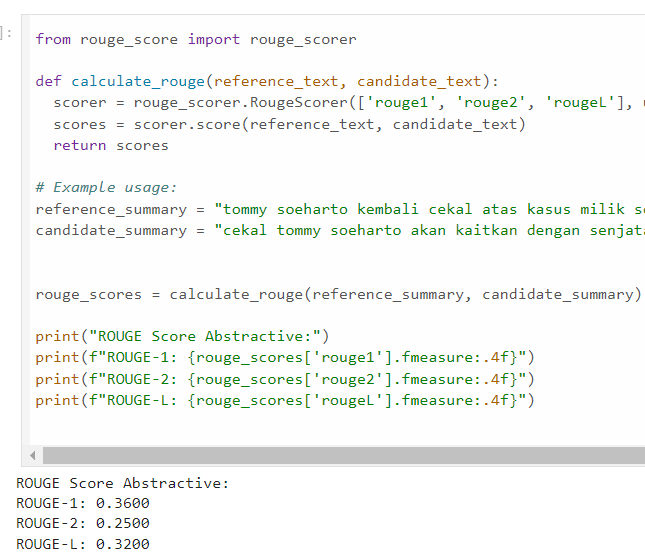

# additional

In [ ]:
test_df_subset = test_df.head(5) # we gonna use this dataset to generate result summarization

In [ ]:
test_df_subset.shape

(5, 3)

In [ ]:
!pip install datasets transformers torch accelerate rouge-score

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.2 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=ed34ee3d39178579a978785296a4989b1121f5ff520597d9ac0dad5af4b6cffa
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
import pandas as pd
import torch
from datasets import load_dataset, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer, DataCollatorForSeq2Seq, EncoderDecoderModel, AutoModelForSeq2SeqLM, AutoTokenizer # Import AutoModelForSeq2SeqLM and AutoTokenizer
from transformers import pipeline

In [ ]:
# Check if GPU is available and set device accordingly
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cpu


In [ ]:
!pip install tqdm  # Install tqdm if you haven't already
from tqdm import tqdm

import pandas as pd

def generate_summaries_for_df(df):
    model_path = "cahya/bert2bert-indonesian-summarization"
    abstractive_summarizer = EncoderDecoderModel.from_pretrained(model_path).to(device)
    tokenizer = BertTokenizer.from_pretrained("cahya/bert2bert-indonesian-summarization")
    tokenizer.bos_token = tokenizer.cls_token
    tokenizer.eos_token = tokenizer.sep_token

    # Generate summary using your model

    abstractive_summaries = []

    # Wrap the loop with tqdm to display a progress bar
    for text in tqdm(df['text'], desc="Generating Summaries"):
        try:
            # Call the original generate_summaries function if it exists, or define it here
            # If 'generate_summaries' is a separate function, ensure it's defined and accessible
            # Example usage if you have a separate 'generate_summaries' function:
            # abstractive_summary = generate_summaries(text, abstractive_summarizer, tokenizer, device)
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)  # Adjust max_length if needed
            summary_ids = abstractive_summarizer.generate(**inputs, max_length=100)  # Adjust max_length if needed
            abstractive_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

            abstractive_summaries.append(abstractive_summary)
        except Exception as e:
            print(f"Error generating summary for text: {text[:50]}...")  # Print a message for debugging
            print(f"Error: {e}")  # Print the error
            abstractive_summaries.append("")  # Append an empty string to keep the output length consistent

    return pd.DataFrame({'abstractive_summary': abstractive_summaries})

# Assuming test_df_subset is already defined
summary_df_subset_raw_b = generate_summaries_for_df(test_df_subset)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Generating Summaries: 100%|██████████| 5/5 [01:43<00:00, 20.63s/it]
